# Does Political Structure Influence Voter Turnout in Industrialized Democracy?

### STAT 301  - Group Project - Final Report

By, Group 6:
- Rohan Joseph
- Alan Lee
- Buyun Wang
- Yifan Wu

In [1]:
# Please install the required packages if not already installed

# install.packages("faux")
# install.packages("leaps")
# install.packages("car")
# install.packages("mltools")

In [2]:
# Load the necessary packages for the Project Report

library(GGally)
library(dplyr)
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(faux)
library(leaps)
library(car)
library(mltools)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

************
Welcome to faux. For support and examples visit:
https://debruine.github.io/faux/
- Get and set global package options with: faux_options()
************


Attaching package: 'faux'


The following object is masked from 'package:purrr':

    %

## 1. Introduction

The two competing explanations for differences in voter turnout between countries in the literature is either cultural or institution-based. The cultural argument traditionally cites Almond and Verba’s (1963) work that turnout depends on the unique, participatory culture of each country. Alternatively, the classic work by Jackman (1987) suggests the structure of a country’s political institutions has a “major and predictable” impact on voting rates regardless of cultural differences (p. 406). However, Jackman’s shortcoming was he could only compare 19 countries in the 1970s. Thus his results might not be generalizable to all elections and industrialized democracies. Subsequent studies mostly focused on country-specific elections but have cast doubt on whether institutional factors have an effect (Freitag, 2010). This study, therefore, aims to test Jackman’s claims that voter turnout is majorly impacted by the structure of political institutions in industrialized democracies by using a more comprehensive and updated dataset.

The QOG dataset will be from the Quality of Government Institute, where researchers compiled measures for each country from hundreds of sources (Teorell et. al., 2022). The dataset has information from 1960 to 2018 for the 36 OECD and EU democracies, however, after cleaning the data, observations for 35 countries remain with data for x elections. We base our methods on Jackman (1987), and will build a regression of the voter turnout against institutional measures of electoral competitiveness, multipartyism, electoral proportionality, and whether the legislature is bicameral. In addition, as our modern dataset has measures for other variables related to government structure, we will also attempt to generate a larger model and compare its ability to explain voter turnout to Jackman’s. The additional variables we test for will be the egalitarianism of the political process and the ability of all social groups to participate, women’s political empowerment in the government, the presence of corruption by the executive, and corruption by the legislature. These additional variables are indexes compiled by 3rd party experts reporting on the country based on relevant criteria. 

The dataset can be found at: https://www.qogdata.pol.gu.se/data/codebook_std_jan22.pdf

Ultimately, we aim to reduce the uncertainty around Jackman’s findings on whether these factors of government institutions are significant in voter turnout and offer an alternative model. By identifying whether reform in institutions might promote more voter participation we hope to encourage more policies to improve voting. 

## 2. Data Wrangling, Cleaning and Explanatory Analysis

### 2.1 Importing the Dataset

In [3]:
url <- "https://www.qogdata.pol.gu.se/data/qog_std_ts_jan22.csv"
QOG_dataset_original <- read_delim(url, ",")

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 15168 Columns: 1913
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr    (7): cname, cname_qog, ccodealp, version, cname_year, ccodealp_year, ...
dbl (1903): ccode, year, ccode_qog, ccodecow, aid_cpnc, aid_cpsc, aid_crnc, ...
lgl    (3): psi_cpsi2, psi_edate2, psi_psi2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2.2 Cleaning the Dataset

***Response:*** *van_part* (how many people go vote at an election)

***Original Variables:*** *van_comp, jw_bicameral, br_pvote, cpds_enps* (competitiveness, bicameral, proportional voting, effective number of parties

***New Variables:*** *vdem_egal, vdem_gender, vdem_gcrrpt, vdem_execorr*
- **vdem_egal:** Index on how much state tries to improve egalitarian measures (The egalitarian principle of democracy holds that material and immaterial inequalities inhibit the exercise of formal rights and liberties, and diminish the ability of citizens from all social groups to participate)
- **vdem_gender:**  Women political empowerment index - Women traditionally are excluded from politics, so how much does policies to improve the number of women in the electoral process, improve turnout?
- **vdem_gcrrpt:** Index of reported corruption in legislature (eg. congress)
- **vdem_execorr:** Index of corruption in executive (eg. president)

***NOTE:*** *vdem_gcrrpt* and *vdem_execorr* are like how does the amount of corruption (stealing money, giving important roles to family and friends, etc) affect people's turn out. Do people show up more to change things or just give up on voting? 

In [4]:
# For cleaning up the dataset we will be doing the following:.
# - We will be renaming our selected variables for better readability.
# - We will be filtering out the NA rows when applicable.

QOG_cleaned <- QOG_dataset_original %>% 
                select(cname, van_part, van_comp, jw_bicameral, br_pvote, cpds_enpv, 
                      vdem_egal, vdem_gender, vdem_gcrrpt, vdem_execorr) 

colnames(QOG_cleaned) <- c("country", "voter_turnout", "elec_comp", "gov_type", "prop_rep", "num_party",
                           "index_ega", "index_woman", "index_legis", "index_exe")

QOG_cleaned <- QOG_cleaned %>%
                mutate(gov_type = ifelse(is.na(gov_type), 0, gov_type)) %>%
                mutate(gov_type = ifelse(gov_type == 0, "unitary", "bicaremel")) %>%
                mutate(prop_rep = ifelse(prop_rep == 0, "no", "yes")) %>%
                filter(country != is.na(country),
                       voter_turnout != is.na(voter_turnout),
                       elec_comp != is.na(elec_comp),
                       gov_type != is.na(gov_type),
                       prop_rep != is.na(prop_rep),
                       num_party != is.na(num_party),
                       index_ega != is.na(index_ega),
                       index_woman != is.na(index_woman),
                       index_legis != is.na(index_legis),
                       index_exe != is.na(index_exe))

head(QOG_cleaned)

country,voter_turnout,elec_comp,gov_type,prop_rep,num_party,index_ega,index_woman,index_legis,index_exe
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,51.0,57.1,unitary,no,2.973527,0.787,0.600,3.071,0.072
Australia,51.1,52.0,unitary,no,2.814222,0.787,0.600,3.071,0.072
Australia,50.1,52.0,unitary,no,2.814222,0.787,0.602,3.071,0.072
Australia,50.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072
Australia,50.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072
Australia,51.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072


In [5]:
QOG_cleaned$gov_type <- as.factor(QOG_cleaned$gov_type) 
QOG_cleaned$prop_rep <- as.factor(QOG_cleaned$prop_rep)

head(QOG_cleaned)

country,voter_turnout,elec_comp,gov_type,prop_rep,num_party,index_ega,index_woman,index_legis,index_exe
<chr>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,51.0,57.1,unitary,no,2.973527,0.787,0.600,3.071,0.072
Australia,51.1,52.0,unitary,no,2.814222,0.787,0.600,3.071,0.072
Australia,50.1,52.0,unitary,no,2.814222,0.787,0.602,3.071,0.072
Australia,50.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072
Australia,50.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072
Australia,51.3,54.5,unitary,no,2.792805,0.787,0.602,3.071,0.072


In [6]:
prop_of_missing_data <- (1 - nrow(QOG_cleaned)/nrow(QOG_dataset_original)) * 100
prop_of_missing_data

[1] 89.03613

As can be seen, only 11% of the data is used in this analysis, whilst the remaining 89% is discarded due the presence of NA (NULL) values in their respective rows. This is a limitation of the dataset as  there is an abundance of accurate election data for developed countries whereas there were often NA entries for developing countries. As such the model is only generalizable to OECD democracies. As developing countries are generally weak states they either do not have full control of their territories or have weak government agencies who cannot accurately record data on their populations.

### 2.3 Summary Tables

We will be building summary tables just to see the averages for the data, by country, government type, and whether there is a proportional representation or not.

**Table 1: Summary of the Data by Country**

In [7]:
QOG_by_country <- QOG_cleaned %>% select(-gov_type, -prop_rep) %>%
                    group_by(country) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party),
                              avg_index_ega = mean(index_ega),
                              avg_index_woman = mean(index_woman),
                              avg_index_legis = mean(index_legis),
                              avg_index_exe = mean(index_exe))
QOG_by_country

country,avg_voter_turnout,avg_elec_comp,avg_num_party,avg_index_ega,avg_index_woman,avg_index_legis,avg_index_exe
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,58.09051,57.47119,3.078265,0.8575763,0.8325085,3.074763,0.046745763
Austria,61.09593,58.54407,3.167171,0.8881864,0.8454407,2.830034,0.068677966
Belgium,60.26864,68.20339,7.853640,0.9311186,0.8678475,3.170831,0.020016949
Bulgaria,53.35724,54.97000,4.442549,0.7773103,0.9119310,1.869793,0.248793103
Canada,44.63186,58.11695,3.312809,0.8449153,0.8678814,2.924237,0.036186441
Croatia,54.46421,51.51158,5.927319,0.8070526,0.9116842,1.865526,0.279368421
Cyprus,46.20209,63.28744,3.681789,0.8071163,0.7395581,2.507535,0.184372093
Czechia,53.00615,65.46923,5.817482,0.9106923,0.9141538,2.699385,0.333192308
Denmark,62.96000,65.84237,5.091167,0.9608475,0.9485932,3.851932,0.004000000


The response variable, the percentage of voter turnout, mostly ranges from 40% to 65% when categorized by country. The explanatory variables are percentage of votes that go to small parties and of multipartyism by the number of influential parties.

**Table 2: Summary of the Data by Government Type**

In [8]:
QOG_by_gov_type <- QOG_cleaned %>% select(-country, -prop_rep) %>%
                    group_by(gov_type) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party),
                              avg_index_ega = mean(index_ega),
                              avg_index_woman = mean(index_woman),
                              avg_index_legis = mean(index_legis),
                              avg_index_exe = mean(index_exe))
QOG_by_gov_type

gov_type,avg_voter_turnout,avg_elec_comp,avg_num_party,avg_index_ega,avg_index_woman,avg_index_legis,avg_index_exe
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bicaremel,55.83911,59.77002,4.587733,0.8791452,0.8701429,2.740141,0.09477049
unitary,53.25492,59.76764,4.305824,0.8779911,0.8539587,2.972946,0.09870793


The mean voter turnout for the unitary government type is lower than that for bicaremelism while the percentage of votes that go to small parties and of multipartyism by the number of influential parties are basically the same for both types.

**Table 3: Summary of the Data by whether there is proportional representation or not**

In [9]:
QOG_by_prop_rep <- QOG_cleaned %>% select(-country, -gov_type) %>%
                    group_by(prop_rep) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party),
                              avg_index_ega = mean(index_ega),
                              avg_index_woman = mean(index_woman),
                              avg_index_legis = mean(index_legis),
                              avg_index_exe = mean(index_exe))
QOG_by_prop_rep

prop_rep,avg_voter_turnout,avg_elec_comp,avg_num_party,avg_index_ega,avg_index_woman,avg_index_legis,avg_index_exe
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,50.66212,56.78629,3.561606,0.8427238,0.8278667,2.909043,0.05741667
yes,55.01874,60.77583,4.654132,0.8903041,0.8683347,2.914564,0.11130732


For a country with proportional representation systems, the average turn out is 5% higher than the country without proportional representation systems. Consistently, the percentage of votes that go to small parties and of multipartyism by the number of influential parties for a country with proportional representation systems are respectively 4% higher and 1% higher than the countries without ones.

### 2.4 Data Visualizations

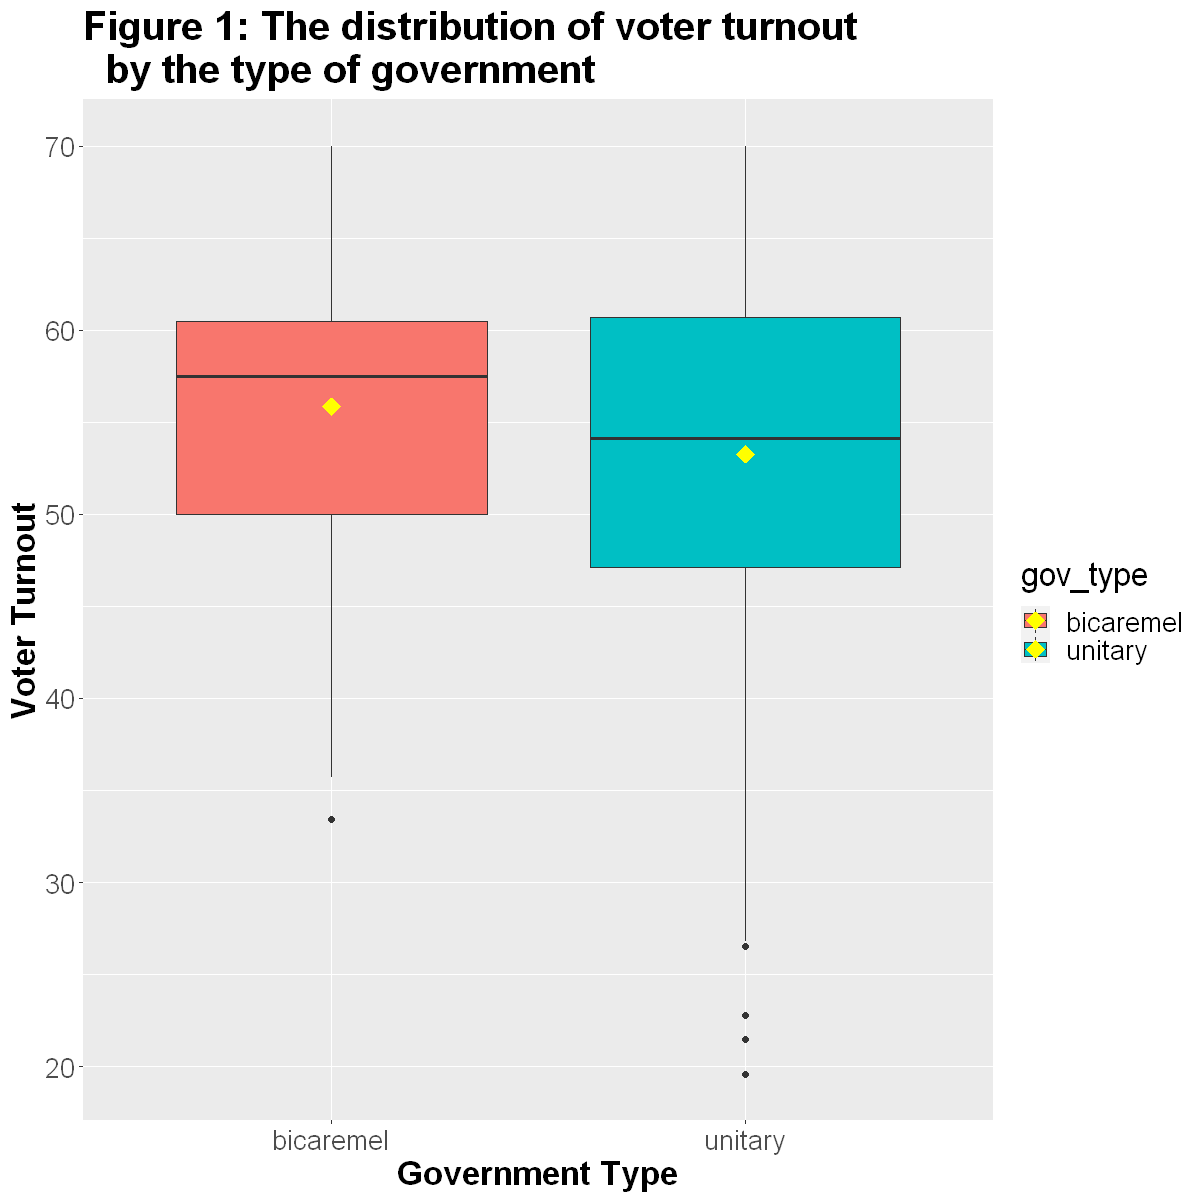

In [10]:
gov_type_boxplots <- QOG_cleaned %>%
  ggplot() +
  geom_boxplot(aes(gov_type, voter_turnout, fill = gov_type)) +
  theme(
    text = element_text(size = 12),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Figure 1: The distribution of voter turnout 
  by the type of government") +
  theme(text = element_text(size = 20)) +
  xlab("Government Type") +
  ylab("Voter Turnout") +
  stat_summary(aes(gov_type, voter_turnout, fill = gov_type),
    fun = mean, colour = "yellow", geom = "point",
    shape = 18, size = 5
  )

options(repr.plot.width = 10, repr.plot.height = 10)

gov_type_boxplots

The mean voter turnout for the unitary government type is 5% lower than that for bicaremelism, however, the variance is larger for unitary than that for bicaremelism. We can also see that there are more outliers for the unitary government type.

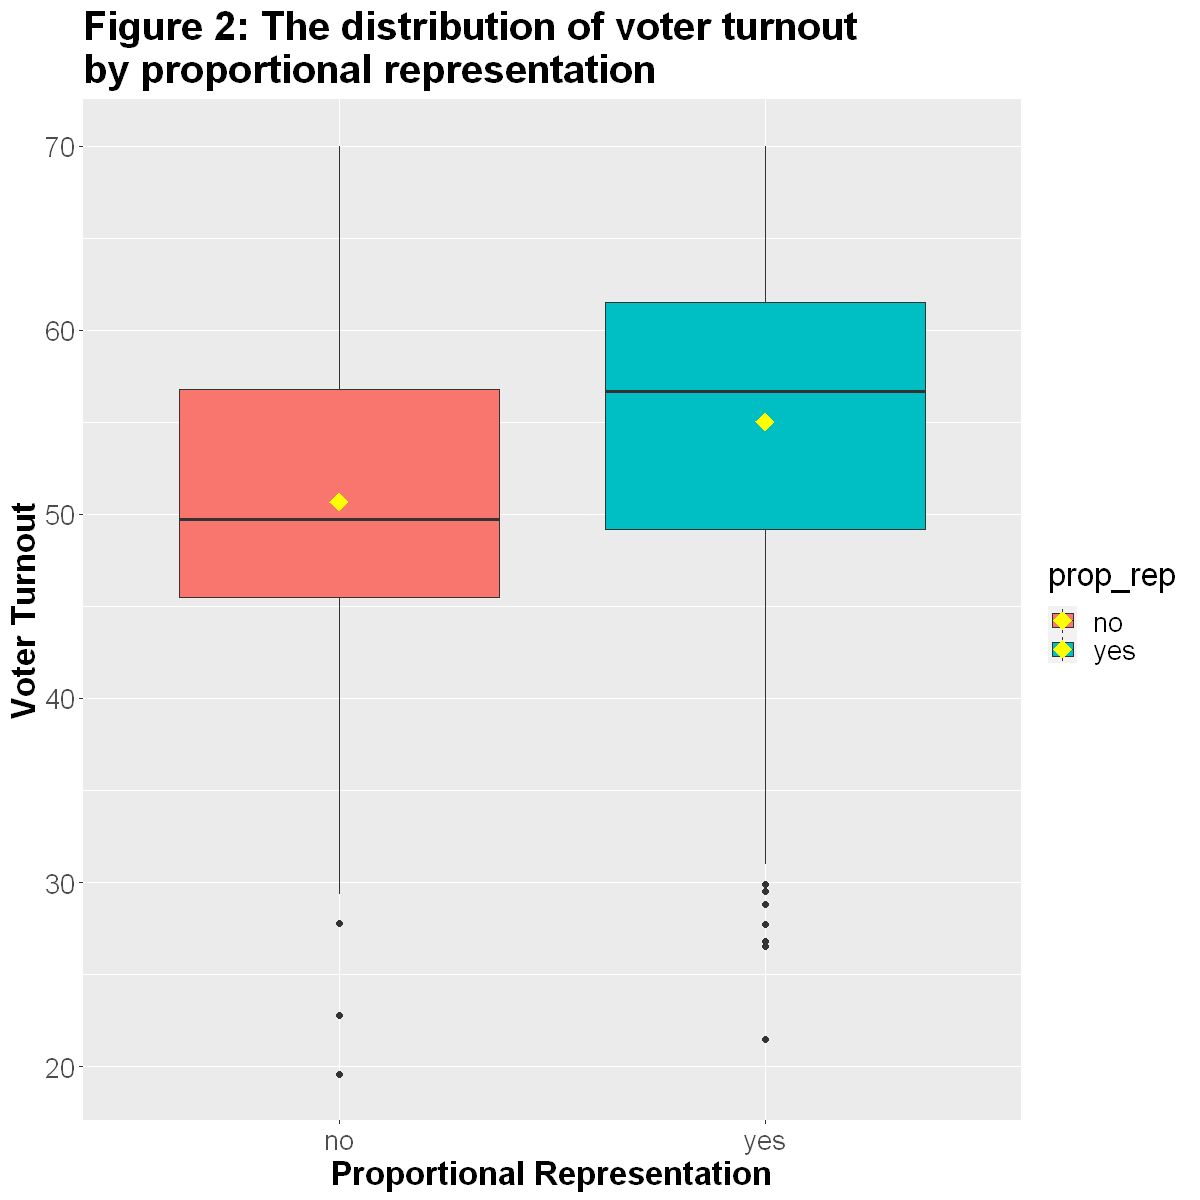

In [11]:
prop_rep_boxplots <- QOG_cleaned %>%
    ggplot() +
    geom_boxplot(aes(prop_rep, voter_turnout, fill = prop_rep)) +
    theme(
      text = element_text(size = 11),
      plot.title = element_text(face = "bold"),
      axis.title = element_text(face = "bold")
    ) +
    ggtitle("Figure 2: The distribution of voter turnout 
by proportional representation") +
    theme(text = element_text(size = 20)) +
    xlab("Proportional Representation") +
    ylab("Voter Turnout") +
    stat_summary(aes(prop_rep, voter_turnout, fill = prop_rep),
      fun = mean, colour = "yellow", geom = "point",
      shape = 18, size = 5
    )

options(repr.plot.width = 10, repr.plot.height = 10)

prop_rep_boxplots

We can see that the mean for yes is 7% higher than the mean for no, with similar variances for both.

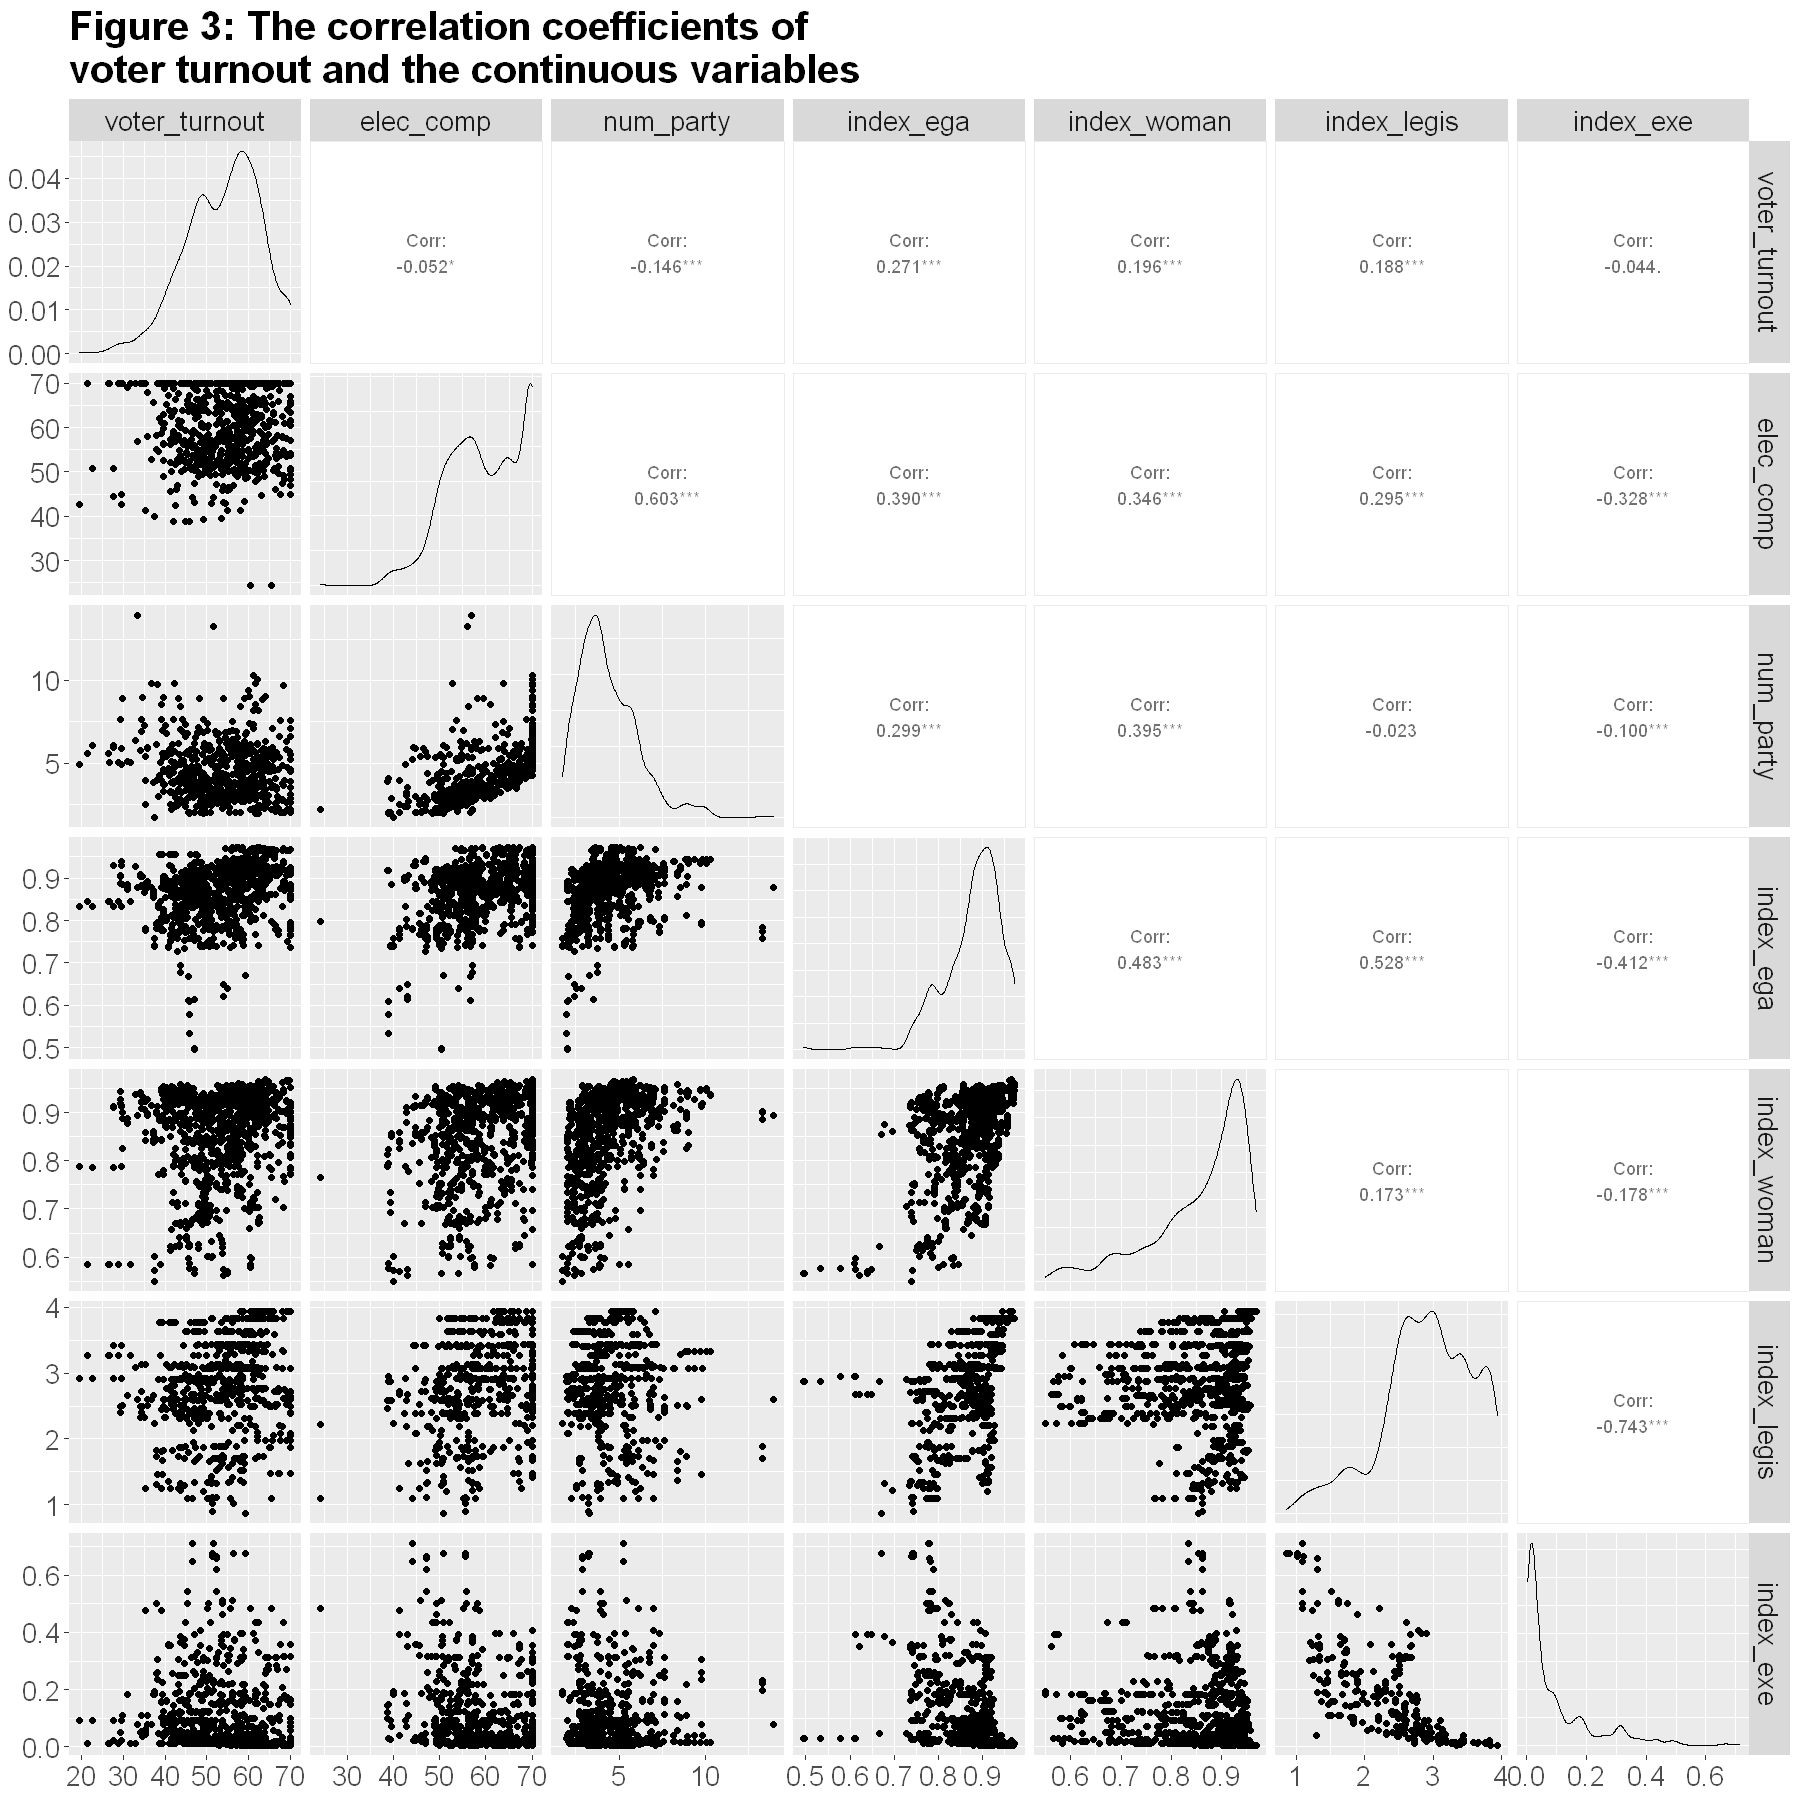

In [12]:
QOG_cleaned_pairplots <- QOG_cleaned %>%
    select(-country, -gov_type, -prop_rep) %>%
    ggpairs(progress = FALSE) +
    theme(
      text = element_text(size = 20),
      plot.title = element_text(face = "bold"),
      axis.title = element_text(face = "bold")
    ) +
    ggtitle("Figure 3: The correlation coefficients of 
voter turnout and the continuous variables") +
    theme(text = element_text(size = 20))

options(repr.plot.width = 15, repr.plot.height = 15)

QOG_cleaned_pairplots

We can see that the correlation graph displays weak correlations between voter turnout and the different explanatory variables, corresponding to a distracted scatterplot. However, the main reason for this particular correlation graph is that our dataset accounts for voter data from a vast time period and a vast selection of countries with differing political landscapes, government structures, etc.

## 3. Methodology and Results

### 3.1 Explaining the Methdology

We estimate institutionalized competition using Vanhanen (2019)’s method based on the percentage of votes that go to small parties, multipartyism by the number of influential parties, electoral proportionality on a dummy whether proportional representation systems exist, and bicameralism (the presence of two legislatures) using a dummy with 0 for unitary and 1 for bicameral governments. Using the above variables, we will recreate Jackman’s model and test if they continue to be significant in describing voter turnout. However, as we now have access to a larger dataset with measures for more variables we also try to generate a larger model that incorporates this additional data. We avoid variables that are outside Jackman’s investigation of government structure but add variables to test for egalitarianism in the political process, empowerment of women, corruption in the legislature, and corruption in the executive. These additional measures were indexes compiled by third party experts reporting on the country. 

We will test the null hypothesis that the structure of a country's government doesn't significantly influence voter turnout. We will build a multiple linear regression model with confidence intervals of its coefficients to estimate the effect of the 4 input variables on voter turnout. Furthermore, we will use the $R^{2}$  value in order to evaluate the performance of our linear regression model and test to see if Jackman’s 4 variables continue to be significant. In addition, we will propose an alternative model by using backward selection to select from the 4 variables Jackman used and from the 4 additional variables available in our dataset that relate to the structure of the government. 

To generate our alternative model for inference testing, we split our available data with 30% for variable selection. Of the remaining 70% of our data, we took another 70% of that and split it to be used as our training data and the rest for our testing. We wanted to maximize how much data we could use for training. As a result 30% of our total cleaned data is used for variable selection, 49% of the total cleaned is used for training and 21% of our total cleaned data is used for testing. To keep the training and testing consistent, both the model based on Jackman’s original research and our new alternative model used the same training and testing datasets. 

The alternative model was created using backward selection which was recommended for inference models. As the model based on Jackman’s only used 4 variables and as we were only proposing 4 additional variables to potentially add to it, we did not find it necessary to use more rigorous methods such as LASSO or Ridge as part of our variable selection. 


### 3.2 Splitting the Data

In [13]:
QOG_cleaned$ID <- 1:nrow(QOG_cleaned)

selection_QOG <- sample_n(QOG_cleaned, size = nrow(QOG_cleaned) * 0.3,
                        replace = FALSE)
model_QOG <- anti_join(QOG_cleaned, 
                        selection_QOG,
                        by = "ID")
training_QOG <- sample_n(model_QOG, size = nrow(model_QOG) * 0.7,
                        replace = FALSE)
testing_QOG <- anti_join(model_QOG, 
                        training_QOG,
                        by = "ID")

selection_QOG <- selection_QOG %>% select(-"ID")
training_QOG <- training_QOG %>% select(-"ID")
testing_QOG <- testing_QOG %>% select(-"ID")

In [14]:
head(training_QOG)

country,voter_turnout,elec_comp,gov_type,prop_rep,num_party,index_ega,index_woman,index_legis,index_exe
<chr>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Denmark,65.8,63.4,unitary,yes,5.252846,0.967,0.954,3.943,0.004
United States of America (the),56.8,49.3,bicaremel,no,2.059830,0.769,0.818,2.870,0.039
Australia,59.9,55.1,bicaremel,no,2.891260,0.884,0.897,3.071,0.034
Italy,62.0,56.2,unitary,yes,3.803221,0.921,0.927,2.038,0.153
Malta,70.0,48.2,unitary,yes,2.044053,0.870,0.807,2.617,0.316
United Kingdom of Great Britain and Northern Ireland (the),52.2,60.7,unitary,no,3.155141,0.833,0.792,3.129,0.014


### 3.3 Model Construction (Jackman)

In [15]:
old_model <- lm(voter_turnout ~ elec_comp + gov_type + prop_rep + num_party, data = training_QOG)
summary(old_model)


Call:
lm(formula = voter_turnout ~ elec_comp + gov_type + prop_rep + 
    num_party, data = training_QOG)

Residuals:
    Min      1Q  Median      3Q     Max 
-31.677  -5.240   0.476   5.519  20.238 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     57.29657    2.42534  23.624  < 2e-16 ***
elec_comp       -0.01757    0.04759  -0.369    0.712    
gov_typeunitary -4.57004    0.67241  -6.796 2.08e-11 ***
prop_repyes      6.81430    0.69875   9.752  < 2e-16 ***
num_party       -0.92233    0.21346  -4.321 1.75e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.158 on 810 degrees of freedom
Multiple R-squared:  0.134,	Adjusted R-squared:  0.1297 
F-statistic: 31.32 on 4 and 810 DF,  p-value: < 2.2e-16


In [16]:
tidy(old_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),57.29657208,2.42533962,23.6241438,2.819537e-94
elec_comp,-0.01756735,0.04759106,-0.3691313,7.121264e-01
gov_typeunitary,-4.57003521,0.67241304,-6.7964702,2.078520e-11
prop_repyes,6.81429641,0.69874845,9.7521453,2.545960e-21
num_party,-0.92232670,0.21346353,-4.3207695,1.748069e-05


In [17]:
vif(old_model)

elec_comp  gov_type  prop_rep num_party 
 1.691193  1.045741  1.164634  1.775475

### 3.4 Backward Selection

In [18]:
turnout_backward_sel <- regsubsets(
  x = voter_turnout ~ elec_comp + gov_type + prop_rep + num_party + index_ega + index_woman + 
                        index_legis + index_exe, 
                        nvmax = 8,
  data = selection_QOG,
  method = "backward",
)

summary(turnout_backward_sel)

Subset selection object
Call: regsubsets.formula(x = voter_turnout ~ elec_comp + gov_type + 
    prop_rep + num_party + index_ega + index_woman + index_legis + 
    index_exe, nvmax = 8, data = selection_QOG, method = "backward", 
    )
8 Variables  (and intercept)
                Forced in Forced out
elec_comp           FALSE      FALSE
gov_typeunitary     FALSE      FALSE
prop_repyes         FALSE      FALSE
num_party           FALSE      FALSE
index_ega           FALSE      FALSE
index_woman         FALSE      FALSE
index_legis         FALSE      FALSE
index_exe           FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: backward
         elec_comp gov_typeunitary prop_repyes num_party index_ega index_woman
1  ( 1 ) " "       " "             " "         "*"       " "       " "        
2  ( 1 ) " "       " "             " "         "*"       "*"       " "        
3  ( 1 ) " "       " "             "*"         "*"       "*"       " "        
4  ( 1 ) " "       "*"  

In [19]:
turnout_bwd_summary <- summary(turnout_backward_sel)

turnout_bwd_summary_df <- data.frame(
    n_input_variables = 1:8,
    RSQ = turnout_bwd_summary$rsq, RSS = turnout_bwd_summary$rss,
    ADJ.R2 = turnout_bwd_summary$adjr2
)

turnout_bwd_summary_df

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.08163521,40295.05,0.07978367
2,0.19168234,35466.52,0.18841641
3,0.20845628,34730.53,0.20364934
4,0.22819796,33864.32,0.22193587
5,0.24089690,33307.13,0.23318243
6,0.24988062,32912.95,0.24071419
7,0.25314595,32769.68,0.24247660
8,0.25342409,32757.48,0.24121017


Based on the summary of the model selection, we can see that the model with 7 input variables has the best performance in terms of the adjusted $R^{2}$ value. Considering the fact that adjusted  $R^{2}$ value is commonly used to compare models with different sizes, we adopted the model with 7 input variables as the new model.

In [20]:
new_model <- lm(voter_turnout ~ elec_comp + gov_type + prop_rep + num_party + index_ega + 
                index_woman+ index_legis,
                data = training_QOG)
summary(new_model)


Call:
lm(formula = voter_turnout ~ elec_comp + gov_type + prop_rep + 
    num_party + index_ega + index_woman + index_legis, data = training_QOG)

Residuals:
     Min       1Q   Median       3Q      Max 
-30.5774  -4.8650   0.5128   4.9791  19.6236 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     31.01884    4.26263   7.277 8.10e-13 ***
elec_comp       -0.17646    0.04775  -3.695 0.000234 ***
gov_typeunitary -4.38440    0.64266  -6.822 1.76e-11 ***
prop_repyes      5.72000    0.69921   8.181 1.09e-15 ***
num_party       -0.99307    0.21058  -4.716 2.84e-06 ***
index_ega       15.53258    5.72332   2.714 0.006791 ** 
index_woman     19.34930    3.44998   5.609 2.80e-08 ***
index_legis      2.22132    0.52854   4.203 2.93e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.648 on 807 degrees of freedom
Multiple R-squared:  0.2416,	Adjusted R-squared:  0.235 
F-statistic: 36.73 on 7 and 807 DF,  p-

In [21]:
tidy(new_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),31.0188426,4.26262934,7.276927,8.102468e-13
elec_comp,-0.1764569,0.04775106,-3.695349,2.344072e-04
gov_typeunitary,-4.3844008,0.64265942,-6.822277,1.758411e-11
prop_repyes,5.7200021,0.69921422,8.180615,1.094528e-15
num_party,-0.9930728,0.21058224,-4.715843,2.835604e-06
index_ega,15.5325759,5.72331841,2.713911,6.791248e-03
index_woman,19.3492982,3.44998401,5.608518,2.803665e-08
index_legis,2.2213158,0.52853725,4.202761,2.931280e-05


In [22]:
vif(new_model)

elec_comp    gov_type    prop_rep   num_party   index_ega index_woman 
   1.937084    1.086810    1.326809    1.965852    2.061610    1.441888 
index_legis 
   1.606655

### 3.5 Model Comparison and Accuracy

In [23]:
anova(old_model, new_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,810,53908.85,NA,NA,NA,NA
2,807,47207.24,3,6701.611,38.18764,4.409684e-23


In [24]:
old_model_pred <- predict(old_model, newdata = testing_QOG)

old_model_RMSE = rmse(preds = old_model_pred,
                      actuals = testing_QOG$voter_turnout)
old_model_RMSE

[1] 8.021545

In [25]:
new_model_pred <- predict(new_model, newdata = testing_QOG)

new_model_RMSE = rmse(preds = new_model_pred,
                      actuals = testing_QOG$voter_turnout)
new_model_RMSE

[1] 7.550619

The *F*-test displays a *p*-value lower than 0.5 (for the new model), therefore, this indicates that, at a 95% confidence interval, the new model is significantly better than the old model. Furthermore, we can see that the new model has a lower Root Mean Squared Error (RMSE) value, further indicating that the new model will have better accuracy in predicting the target value.

## 4. Discussion

Our study aimed to test Jackman’s claims that voter turnout is majorly impacted by the structure of political institutions in industrialized democracies by using a more comprehensive and updated dataset. We based out methods on Jackman (1987) in building a regression model with additional variables, with the aim in reducing the uncertainty around Jackman’s findings on whether these factors of government institutions are significant in voter turnout by offering an alternative model. We were able to conclude that our updated model had a better goodness-of-fit (as represented by its higher $R^{2}$ value), as well as better accuracy (as represented by its lower RMSE value), than Jackman's original model.

Despite the advantages of using a larger dataset than Jackman, the results of our inference test and alternative model could still be improved. One limitation of the current dataset is that there is an abundance of accurate election data for developed countries whereas there were often NA entries for developing countries. As such the model is only generalizable to OECD democracies. As developing countries are generally weak states they either do not have full control of their territories or have weak government agencies who cannot accurately record data on their populations. This means future data will need to be gathered by non government organizations or academics which may be difficult or extremely costly to do for all countries. However, as the majority of all countries resemble weak states and as the OECD democracies are more of a unique exception in history, it will be useful to gather this data. By being able to generalize these claims to all democracies, we can determine what parts of government structure would be useful in enabling high voter turnout for much of the world or alternatively we could use this data to focus on how to improve voter turnout in the developing world. 

Besides improving the generalizability of our model, it could also be improved with more data on different aspects of government structure to see if we can find more significant variables. Although our dataset was large, many variables did not relate to government structure or if they did have data for all years. Expanding the data could also allow us to identify more important parts of government structure and its effect on voting. 

There is already much research on how factors within society like education affect voter turnout. This research tests whether the structure of government and how we operate political organizations affects citizen’s participation in voting. By doing so we hope to renew interest in identifying other features of government that may affect voter turnout and also suggest creating a more generalizable model that includes data from additional states such as developing countries.

## 5. References

Almond, G. A., & Verba, S. (1963). The Civic Culture: Political Attitudes And Democracy In Five Nations. Princeton University Press.

Freitag, M. (2010). Structure versus Culture: A Comparative Study of the Influence of Political Institutions and Cultural Modernization Factors on Voter Turnout in Swiss Sub-national Parliamentary Elections. International Political Science Review / Revue Internationale de Science Politique, 31(4), 428–448. http://www.jstor.org/stable/20869812

Jackman, R. W. (1987). Political Institutions And Voter Turnout In The Industrial Democracies. The American Political Science Review, 81(2), 405-423. https://doi.org/10.2307/1961959

Teorell, J., Sundström A., Holmberg, S., Rothstein B., Alvarado, N., Cem Mert Dalli, P. & C. (2022). The Quality of Government Standard Dataset. University of Gothenburg: The Quality of Government Institute. https://www.gu.se/en/quality-government doi:10.18157/qogstdjan22

Vanhanen, T. (2019). Measures of democracy 1810-2018 [dataset] [Version 8.0]. https://services.fsd.tuni.fi/catalogue/FSD1289